## 훈련 데이터 준비

In [5]:
import re

def clean_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        book_text = file.read()

    cleaned_text = re.sub(r'\n+', ' ', book_text) # 줄바꿈을 빈칸으로 변경
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text) # 여러 빈칸을 하나의 빈칸으로

    print("cleaned_" + filename, len(cleaned_text), "characters") # 글자 수 출력

    with open("cleaned_" + filename, 'w', encoding='utf-8') as file:
        file.write(cleaned_text)

filenames_list = ["02 Harry Potter and the Chamber of Secrets.txt"]

for filename in filenames_list:
    clean_text(filename)

cleaned_02 Harry Potter and the Chamber of Secrets.txt 488771 characters


## 토큰화
UTF-8 BPE(Byte Pair Encoding)

In [6]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

text = "Harry Potter was a wizard."

tokens = tokenizer.encode(text)

print("글자수:", len(text), "토큰수:", len(tokens))
print(tokens)
print(tokenizer.decode(tokens))
for t in tokens:
    print(f"{t}\t -> {tokenizer.decode([t])}")

글자수: 26 토큰수: 6
[18308, 14179, 373, 257, 18731, 13]
Harry Potter was a wizard.
18308	 -> Harry
14179	 ->  Potter
373	 ->  was
257	 ->  a
18731	 ->  wizard
13	 -> .


In [7]:
# from transformers import AutoTokenizer # pip install transformers

# tokenizer = AutoTokenizer.from_pretrained("LGAI-EXAONE/EXAONE-3.5-7.8B-Instruct")  # KoGPT2 사용
# # tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")  # KoGPT2 사용

# print("Vocab size :", len(tokenizer))

# text = "대사께서는 도(道)를 얻은 모양이구려."

# tokens = tokenizer.encode(text)

# print(len(text), len(tokens))
# print(tokens)
# print(tokenizer.decode(tokens))

In [8]:
for char in text:
    token_ids = tokenizer.encode(char)
    decoded = tokenizer.decode(token_ids)
    print(f"{char} -> {token_ids} -> {decoded}")

H -> [39] -> H
a -> [64] -> a
r -> [81] -> r
r -> [81] -> r
y -> [88] -> y
  -> [220] ->  
P -> [47] -> P
o -> [78] -> o
t -> [83] -> t
t -> [83] -> t
e -> [68] -> e
r -> [81] -> r
  -> [220] ->  
w -> [86] -> w
a -> [64] -> a
s -> [82] -> s
  -> [220] ->  
a -> [64] -> a
  -> [220] ->  
w -> [86] -> w
i -> [72] -> i
z -> [89] -> z
a -> [64] -> a
r -> [81] -> r
d -> [67] -> d
. -> [13] -> .


## 데이터로더(DataLoader)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, txt, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # token_ids = tokenizer.encode("<|endoftext|>" + txt, allowed_special={"<|endoftext|>"})
        token_ids = tokenizer.encode(txt)

        print("# of tokens in txt:", len(token_ids))

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1 : i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

# with open("cleaned_한글문서.txt", 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
with open("cleaned_02 Harry Potter and the Chamber of Secrets.txt", 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
    txt = file.read()

dataset = MyDataset(txt, max_length = 32, stride = 4)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

# 주의: 여기서는 코드를 단순화하기 위해 test, valid는 생략하고 train_loader만 만들었습니다.

# of tokens in txt: 130520


In [10]:
dataiter = iter(train_loader)

x, y = next(dataiter) # x, y <- self.input_ids[idx], self.target_ids[idx]

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y[0].tolist()))

 exactly like the sort of thing Malfoy would do. Had Harry been stupid to take Dobby seriously? “I’m glad we came to get you
 like the sort of thing Malfoy would do. Had Harry been stupid to take Dobby seriously? “I’m glad we came to get you,


## 뉴럴네트워크 모델 정의

In [11]:
# 모델을 정의할 때 사용하는 상수들

VOCAB_SIZE = tokenizer.n_vocab # 50257 Tiktoken
#VOCAB_SIZE = len(tokenizer) # AutoTokenizer
CONTEXT_LENGTH = 128  # Shortened context length (orig: 1024)
EMB_DIM = 768  # Embedding dimension
NUM_HEADS = 12  # Number of attention heads
NUM_LAYERS = 12  # Number of layers
DROP_RATE = 0.1  # Dropout rate
QKV_BIAS = False  # Query-key-value bias

In [12]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()

        assert d_out % NUM_HEADS == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.head_dim = d_out // NUM_HEADS

        self.W_query = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_key = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_value = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(DROP_RATE)
        self.register_buffer('mask', torch.triu(torch.ones(CONTEXT_LENGTH, CONTEXT_LENGTH), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, NUM_HEADS, self.head_dim)
        values = values.view(b, num_tokens, NUM_HEADS, self.head_dim)
        queries = queries.view(b, num_tokens, NUM_HEADS, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(EMB_DIM, 4 * EMB_DIM),
            GELU(),
            nn.Linear(4 * EMB_DIM, EMB_DIM),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=EMB_DIM,
            d_out=EMB_DIM)

        self.ff = FeedForward()
        self.norm1 = LayerNorm(EMB_DIM)
        self.norm2 = LayerNorm(EMB_DIM)
        self.drop_shortcut = nn.Dropout(DROP_RATE)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(VOCAB_SIZE, EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, EMB_DIM)
        self.drop_emb = nn.Dropout(DROP_RATE)

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock() for _ in range(NUM_LAYERS)])

        self.final_norm = LayerNorm(EMB_DIM)
        self.out_head = nn.Linear(EMB_DIM, VOCAB_SIZE, bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## 훈련

In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(123)
model = GPTModel()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

cuda


In [16]:
from tqdm import tqdm

tokens_seen, global_step = 0, -1
losses = []

for epoch in range(20):
    model.train()
    epoch_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/20")

    for input_batch, target_batch in pbar:
        optimizer.zero_grad()

        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        logits = model(input_batch)

        loss = torch.nn.functional.cross_entropy(
            logits.flatten(0, 1),
            target_batch.flatten()
        )

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        tokens_seen += input_batch.numel()
        global_step += 1

        # tqdm 우측에 실시간 정보 표시
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "tokens": tokens_seen
        })

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    print(f"\nEpoch {epoch+1} finished | Avg Loss: {avg_loss:.4f}")

    torch.save(
        model.state_dict(),
        f"model_{str(epoch + 1).zfill(3)}.pth"
    )

Epoch 1/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.7689, tokens=1040384]



Epoch 1 finished | Avg Loss: 1.3094


Epoch 2/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.4306, tokens=2080768]



Epoch 2 finished | Avg Loss: 0.4942


Epoch 3/20: 100%|██████████| 254/254 [04:38<00:00,  1.09s/it, loss=0.3340, tokens=3121152]



Epoch 3 finished | Avg Loss: 0.3318


Epoch 4/20: 100%|██████████| 254/254 [04:38<00:00,  1.10s/it, loss=0.2931, tokens=4161536]



Epoch 4 finished | Avg Loss: 0.2824


Epoch 5/20: 100%|██████████| 254/254 [04:38<00:00,  1.09s/it, loss=0.2844, tokens=5.2e+6]



Epoch 5 finished | Avg Loss: 0.2598


Epoch 6/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2590, tokens=6242304]



Epoch 6 finished | Avg Loss: 0.2473


Epoch 7/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2580, tokens=7282688]



Epoch 7 finished | Avg Loss: 0.2390


Epoch 8/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2714, tokens=8323072]



Epoch 8 finished | Avg Loss: 0.2334


Epoch 9/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2367, tokens=9363456]



Epoch 9 finished | Avg Loss: 0.2283


Epoch 10/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2460, tokens=1.04e+7]



Epoch 10 finished | Avg Loss: 0.2229


Epoch 11/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2251, tokens=1.14e+7]



Epoch 11 finished | Avg Loss: 0.2188


Epoch 12/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2115, tokens=1.25e+7]



Epoch 12 finished | Avg Loss: 0.2155


Epoch 13/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2247, tokens=1.35e+7]



Epoch 13 finished | Avg Loss: 0.2137


Epoch 14/20: 100%|██████████| 254/254 [04:38<00:00,  1.09s/it, loss=0.2211, tokens=1.46e+7]



Epoch 14 finished | Avg Loss: 0.2106


Epoch 15/20: 100%|██████████| 254/254 [04:38<00:00,  1.09s/it, loss=0.2194, tokens=1.56e+7]



Epoch 15 finished | Avg Loss: 0.2080


Epoch 16/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2420, tokens=1.66e+7]



Epoch 16 finished | Avg Loss: 0.2059


Epoch 17/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2150, tokens=1.77e+7]



Epoch 17 finished | Avg Loss: 0.2043


Epoch 18/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2116, tokens=1.87e+7]



Epoch 18 finished | Avg Loss: 0.2026


Epoch 19/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2063, tokens=1.98e+7]



Epoch 19 finished | Avg Loss: 0.2003


Epoch 20/20: 100%|██████████| 254/254 [04:37<00:00,  1.09s/it, loss=0.2130, tokens=2.08e+7]



Epoch 20 finished | Avg Loss: 0.1994


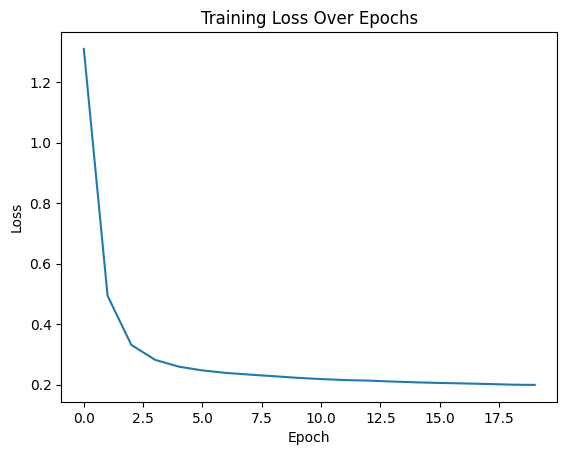

In [17]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

## 결과 확인

In [18]:
# 파일로 저장했던 네트워크의 가중치들 읽어들이기
model.load_state_dict(torch.load("model_020.pth", map_location=device, weights_only=True))
model.eval() # dropout을 사용하지 않음

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [19]:
idx = tokenizer.encode("Dobby is") # 토큰 id의 list
idx = torch.tensor(idx).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(idx)

logits = logits[:, -1, :]

# 가장 확률이 높은 단어 10개 출력
top_logits, top_indices = torch.topk(logits, 10)
for p, i in zip(top_logits.squeeze(0).tolist(), top_indices.squeeze(0).tolist()):
    print(f"{p:.2f}\t {i}\t {tokenizer.decode([i])}")

# 가장 확률이 높은 단어 출력
idx_next = torch.argmax(logits, dim=-1, keepdim=True)
flat = idx_next.squeeze(0) # 배치 차원 제거 torch.Size([1])
out = tokenizer.decode(flat.tolist()) # 텐서를 리스트로 바꿔서 디코드
print(out)

13.09	 257	  a
11.29	 973	  used
10.17	 4978	  caught
8.76	 635	  also
8.53	 30	 ?
8.51	 1464	  always
8.01	 655	  just
7.88	 13	 .
7.85	 262	  the
7.80	 1479	  free
 a


In [20]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [23]:
start_context = input("Start context: ")

# idx = tokenizer.encode(start_context, allowed_special={'<|endoftext|>'})
idx = tokenizer.encode(start_context)
idx = torch.tensor(idx).unsqueeze(0)

context_size = model.pos_emb.weight.shape[0]

for i in range(10):

    token_ids = generate(
        model=model,
        idx=idx.to(device),
        max_new_tokens=10,
        context_size= context_size,
        top_k=10,
        temperature=100
    )

    flat = token_ids.squeeze(0) # remove batch dimension
    out = tokenizer.decode(flat.tolist()).replace("\n", " ")

    print(i, ":", out)

Start context: Dobby is
0 : Dobby is also warning the culprit door — died quite suddenly became
1 : Dobby is free without Mum got his own powers rival are named
2 : Dobby is a dark stone tunnel at Hogwarts? Someone opened the
3 : Dobby is also! Broantly all records! SIL son must
4 : Dobby is also stowed. So. I tell Crab Lord
5 : Dobby is always a diversion in front seats as the dish shattered
6 : Dobby is? � coming toward me, Harry Potter — �
7 : Dobby is also all these attacks,� history is to start
8 : Dobby is also st times to death here, Weasley? Plenty
9 : Dobby is the monster it. He. Very fortunate someone be
